In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hrHgANwgC8VyXLhXgxLYHTrILpeJ5bLl
!unzip /content/mars_and_moon.zip

Downloading...
From: https://drive.google.com/uc?id=1hrHgANwgC8VyXLhXgxLYHTrILpeJ5bLl
To: /content/mars_and_moon.zip
100% 77.6M/77.6M [00:00<00:00, 220MB/s]
Archive:  /content/mars_and_moon.zip
  inflating: best.pt                 
  inflating: craters/test/images/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg  
  inflating: craters/test/images/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg  
  inflating: craters/test/images/019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg  
  inflating: craters/test/images/04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg  
  inflating: craters/test/images/mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg  
  inflating: craters/test/images/mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg  
  inflating: craters/test/images/mars_crater--116-_jpg.rf.2e550a693a8800808e68848484716b95.jpg  
  inflating: craters/test/images/mars_crater--117-_jpg.rf.b412b6593d102c5f9dda7bce79bb815c.jpg  
  inflating: craters/test/images/mars_crater--12-

In [3]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python

#Copy and unify the train and validation datasets into one folder for images and another for labels
!mkdir ./train
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/. ./train/images/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/train/labels/. ./train/labels/
!cp -a /kaggle/input/martianlunar-crater-detection-dataset/craters/valid/labels/. ./train/labels/

Cloning into 'vision'...
remote: Enumerating objects: 424635, done.
remote: Counting objects: 100% (5097/5097), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 424635 (delta 4790), reused 5049 (delta 4764), pack-reused 419538
Receiving objects: 100% (424635/424635), 840.09 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (393886/393886), done.
fatal: not a git repository (or any of the parent directories): .git
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-juuxksko
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-juuxksko
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375458 sha256=e7a2a4909ea3ac1c067671327f8fc130436e279f6a264a6fa6b47fea73a8f38f
  Stored in directory: /tmp/pip-ephe

In [4]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import KFold
import random

def get_model_bbox(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)




In [5]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background','Crater']

    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def get_model_bbox(num_classes):
    # Cargar el modelo pre-entrenado
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Obtener el número de características de entrada para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplazar el clasificador con un nuevo clasificador personalizado
    model.roi_heads.box_predictor = torch.nn.Sequential(
        torch.nn.Linear(in_features, 256),  # Por ejemplo, puedes ajustar el número de neuronas
        torch.nn.ReLU(),
        torch.nn.Linear(256, num_classes)  # Ajustar el número de clases
    )

    return model


In [7]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [8]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [9]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

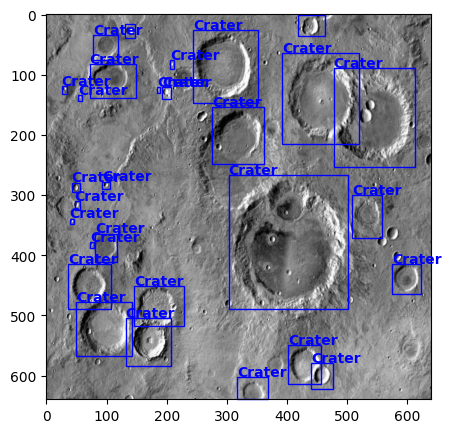

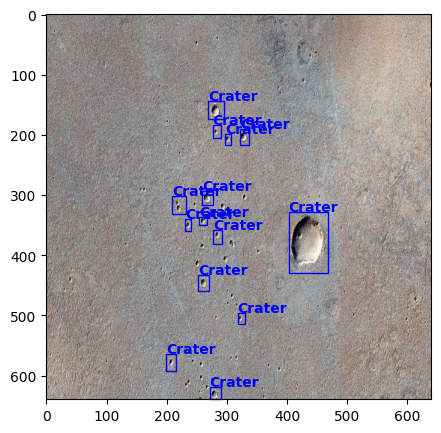

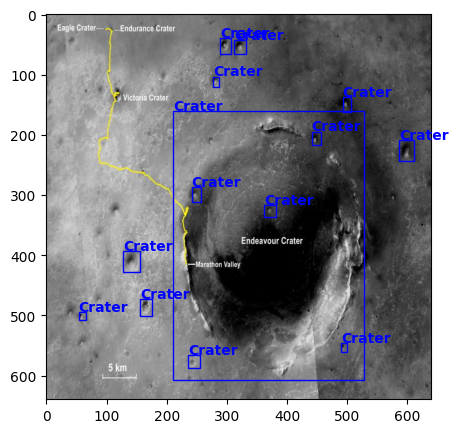

In [10]:
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

In [11]:
import torch

# Define the train_one_epoch function for training
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50):
    model.train()  # Set the model to training mode

    for iteration, batch in enumerate(data_loader):
        images, targets = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # Calculate the total loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        # Perform backpropagation and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if iteration % print_freq == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Iteration [{iteration}/{len(data_loader)}] Loss: {loss_value:.4f}")

# Continue with the rest of your code
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
k_folds = 5
num_epochs = 5

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
dataset_val = CraterDataset('/content/craters/train', get_transform(train=False))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
    dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
            dataset_subset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_bbox(num_classes)

    #model.apply(reset_weights) # Check if beneficial

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                momentum=0.9, weight_decay=0)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=10,
                                                    gamma=0.1)

    # let's train!
    for epoch in range(num_epochs):


        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()






--------------------------------
FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 160MB/s]


ValueError: ignored

In [12]:
num_epochs = 5

# our dataset has two classes only - background and crater
num_classes = 2
# use our dataset and defined transformations
dataset = CraterDataset('/content/craters/train', get_transform(train=True))
dataset_test = CraterDataset('/content/craters/train', get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_bbox(num_classes)

'''
Use this to reset all trainable weights
model.apply(reset_weights)
'''

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,  # Feel free to play with values
                            momentum=0.9, weight_decay=0)

# Defining learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=20,
                                                gamma=0.2)


result_mAP = []
best_epoch = None

# Let's train!
for epoch in range(num_epochs):


    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()

ValueError: ignored

In [ ]:
dataset_test = CraterDataset('/content/craters/train', get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

model = get_model_bbox(num_classes)

In [ ]:
# Define colors for bounding boxes
color_inference = np.array([0.0,0.0,255.0])
color_label = np.array([255.0,0.0,0.0])

# Score value thershold for displaying predictions
detection_threshold = 0.7
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

!mkdir ./results

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

# Define los colores
color_inference = (0, 0, 255)  # Rojo
color_label = (0, 255, 0)  # Verde

total_fps = 0
frame_count = 0

model.eval()  # Cambia el modelo al modo de evaluación (no entrenamiento)
model.to(device)  # Mueve el modelo al dispositivo (CPU o GPU) adecuado

with torch.no_grad():
    for i, data in enumerate(data_loader_test):
        # get the image file name for predictions file name
        image_name = 'image no:' + str(int(data[1][0]['image_id']))
        model_image = data[0][0]
        cv2_image = np.transpose(model_image.numpy() * 255, (1, 2, 0)).astype(np.float32)
        cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR).astype(np.float32)

        # add batch dimension
        model_image = torch.unsqueeze(model_image, 0).to(device)  # Mueve la entrada al dispositivo
        start_time = time.time()

        outputs = model(model_image)

        end_time = time.time()
        # get the current fps
        fps = 1 / (end_time - start_time)
        # add `fps` to `total_fps`
        total_fps += fps
        # increment frame count
        frame_count += 1
        # load all detections to CPU for further operations
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        # carry further only if there's detected boxes
        if len(outputs[0]['boxes']) != 0:
            boxes = outputs[0]['boxes'].data.numpy()
            scores = outputs[0]['scores'].data.numpy()
            # filter out boxes according to `detection_threshold`
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = np.round(scores[scores >= detection_threshold], 2)
            draw_boxes = boxes.copy()

            # draw the bounding boxes and write the class name on top of it
            for j, box in enumerate(draw_boxes):
                cv2.rectangle(cv2_image,
                              (int(box[0]), int(box[1]), int(box[2]), int(box[3])),
                              color_inference, 2)
                cv2.putText(img=cv2_image, text="Crater",
                            org=(int(box[0]), int(box[1] - 5)),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=color_inference,
                            thickness=1, lineType=cv2.LINE_AA)
                cv2.putText(img=cv2_image, text=str(scores[j]),
                            org=(int(box[0]), int(box[1] + 8)),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=color_inference,
                            thickness=1, lineType=cv2.LINE_AA)

            # add boxes for labels
            for box in data[1][0]['boxes']:
                cv2.rectangle(cv2_image,
                              (int(box[0]), int(box[1]), int(box[2]), int(box[3])),
                              color_label, 2)
                cv2.putText(img=cv2_image, text="Label",
                            org=(int(box[0]), int(box[1] - 5)),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3, color=color_label,
                            thickness=1, lineType=cv2.LINE_AA)

            # set size
            plt.figure(figsize=(10, 10))
            plt.axis("off")

            # convert color from CV2 BGR back to RGB
            plt_image = cv2.cvtColor(cv2_image / 255.0, cv2.COLOR_BGR2RGB)
            plt.imshow(plt_image)
            plt.show()
            cv2.imwrite(f"./results/{image_name}.jpg", cv2_image)
        print(f"Image {i + 1} done...")
        print('-' * 50)

print('TEST PREDICTIONS COMPLETE')

avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")